In [ ]:
!pip install -q transformers datasets

     |████████████████████████████████| 5.5 MB 8.9 MB/s 
     |████████████████████████████████| 451 kB 60.9 MB/s 
     |████████████████████████████████| 182 kB 67.9 MB/s 
     |████████████████████████████████| 7.6 MB 42.3 MB/s 
     |████████████████████████████████| 115 kB 55.2 MB/s 
     |████████████████████████████████| 212 kB 67.9 MB/s 
     |████████████████████████████████| 127 kB 69.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from transformers import AutoTokenizer, TFAutoModel
from transformers import logging
logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

clean = re.compile('<.*?>')
code_re = re.compile('<code>.*?<\/code>')


In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("pacovaldez/stackoverflow-questions")

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/pacovaldez___parquet/pacovaldez--stackoverflow-questions-17649feb9c23ae7a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'body', 'label'],
        num_rows: 1572294
    })
    test: Dataset({
        features: ['title', 'body', 'label'],
        num_rows: 1570866
    })
    validation: Dataset({
        features: ['title', 'body', 'label'],
        num_rows: 785098
    })
})

In [ ]:
raw_datasets['test'][0]

{'title': 'How to create sequential number column in pyspark dataframe?',
 'body': '<p>I would like to create column with sequential numbers in <strong>pyspark</strong> dataframe starting from specified number. For instance, I want to add column <strong>A</strong> to my dataframe <strong>df</strong> which will start from <strong>5</strong> to the length of my dataframe, incrementing by one, so <strong>5</strong>, <strong>6</strong>, <strong>7</strong>, ..., <em>length</em>(<strong>df</strong>). </p>\n\n<p>Some simple solution using <strong>pyspark</strong> methods?</p>',
 'label': 0}

In [ ]:
# model_checkpoint = "bert-base-uncased"
model_checkpoint = "vinai/bertweet-base"
batch_size = 8

In [ ]:
from transformers import AutoTokenizer, TFAutoModel


tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModel.from_pretrained(model_checkpoint)


In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    return re.sub(clean, '', text)

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('\n', ' ')
    sentence = sentence.replace('&quot;', '')
    sentence = sentence.replace(',', ' ')
    sentence = sentence.replace('(', ' ')
    sentence = sentence.replace(')', ' ')
    sentence = sentence.replace('*', ' ')
    sentence = sentence.replace('-', ' ')
    sentence = sentence.replace('_', ' ')
    sentence = sentence.replace('.', ' ')
    sentence = sentence.replace('?', ' ')
    sentence = sentence.replace('!', ' ')
    sentence = sentence.replace(';', ' ')
    sentence = sentence.replace('"', ' ')
    sentence = sentence.replace('\'', '')
    sentence = sentence.replace('$', ' ')
    sentence = sentence.replace('%', ' ')
    sentence = sentence.replace('}', ' ')
    sentence = sentence.replace('{', ' ')
    sentence = sentence.replace(':', ' ')
    sentence = sentence.replace('[', ' ')
    sentence = sentence.replace(']', ' ')
    return sentence

def postprocess(sentence):
    sentence = sentence.replace('/', ' ')
    sentence = sentence.replace('  ', ' ')
    sentence = sentence.replace('  ', ' ')
    return sentence

def replace_code_tag_token(text):
    """replace code tag with token"""
    text = text.replace('\n', ' ')  
    return re.sub(code_re, ' [CODE] ', text)



def merge_and_process_text(dataset):
  dataset['text'] = dataset['title'] + ' ' + dataset['body']
  dataset['text'] = preprocess(dataset['text'])
  dataset['text'] = remove_html_tags(dataset['text'])
  dataset['text'] = postprocess(dataset['text'])
  dataset['text'] = dataset['text'][:600]
  return dataset

merge_and_process_text(raw_datasets['train'][0])

{'title': 'Parsing json directly using input stream',
 'body': '<p>I am doing a api call and in response i am getting json. So for that I want to parse it directly through input stream so that there would not be need of storing it in memory. \nFor this I am trying to use JSONReader but that i am unable use for api\'s less than 11.\nSo i dont know how to proceed with. I want it to be done from 2.0 version onwards. Even parsing through JsonReader is not working.\nI was thing of having GSON parser but i am not getting how to implement the same with Inputstream.</p>\n\n<p>EDIT:\nMy code for the same:</p>\n\n<pre><code>HttpClient client = new DefaultHttpClient();\nHttpGet httpGet = new HttpGet(url);\n\ntry {\n          HttpResponse response = client.execute(httpGet);\n          StatusLine statusLine = response.getStatusLine();\n          int statusCode = statusLine.getStatusCode();\n          Log.e("123", "Status code ----------- "+statusCode);\n          if (statusCode == 200) { \n        

In [ ]:

clean_dataset_test = raw_datasets['test'].shuffle(seed=42).shard(num_shards=5, index=0).map(merge_and_process_text)
clean_dataset_train = raw_datasets['train'].shuffle(seed=42).shard(num_shards=5, index=0).map(merge_and_process_text)
clean_dataset_validation = raw_datasets['validation'].shuffle(seed=42).shard(num_shards=5, index=0).map(merge_and_process_text)

  0%|          | 0/78544 [00:00<?, ?ex/s]

  0%|          | 0/78615 [00:00<?, ?ex/s]

  0%|          | 0/39255 [00:00<?, ?ex/s]

In [ ]:
max_length = 128


In [ ]:
cleantrain_encodings = tokenizer(clean_dataset_train['text'], truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
cleanvalid_encodings = tokenizer(clean_dataset_validation['text'], truncation=True, padding=True, max_length=max_length, return_tensors='tf')


In [ ]:
cleantest_encodings = tokenizer(clean_dataset_test['text'], truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
def build_model(bert_model, max_length, last_layer_num, drop_out=0.3):
    # Freeze all but layer_11 and pooler layers
    for w in bert_model.weights:
        if 'layer_._%d' % last_layer_num not in w.name:
            w._trainable = False

    input_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')
    
    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    cls_output = bert_output[0][:, 0, :]

    dropout_output = keras.layers.Dropout(drop_out)(cls_output)
    final_output = keras.layers.Dense(4, activation="softmax")(dropout_output)
    
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
cleantrain_encodings["input_ids"]

<tf.Tensor: shape=(78615, 128), dtype=int32, numpy=
array([[    0,   510,  4697, ...,     1,     1,     1],
       [    0, 24385, 38154, ...,     1,     1,     1],
       [    0,    84,     9, ...,   483,  4591,     2],
       ...,
       [    0,  2100,  3524, ...,     1,     1,     1],
       [    0,  4818,    30, ...,     2,     1,     1],
       [    0,    66,     6, ...,     1,     1,     1]], dtype=int32)>

In [ ]:
bert_model = build_model(
    model,
    max_length,
    11
)

In [ ]:
train_inputs = [
        cleantrain_encodings["input_ids"],
        cleantrain_encodings["attention_mask"],
        cleantrain_encodings["token_type_ids"]
    ]

valid_inputs = [
        cleanvalid_encodings["input_ids"],
        cleanvalid_encodings["attention_mask"],
        cleanvalid_encodings["token_type_ids"]
    ]

In [ ]:
bert_model.fit(
    train_inputs,
    np.array(clean_dataset_train['label']),
    validation_data=[valid_inputs, np.array(clean_dataset_validation['label'])],
    epochs=4,
)

Epoch 1/4


2457/2457 [==============================] - 1123s 454ms/step - loss: 1.3784 - accuracy: 0.3029 - val_loss: 1.3508 - val_accuracy: 0.3354
Epoch 2/4
2457/2457 [==============================] - 1115s 454ms/step - loss: 1.3465 - accuracy: 0.3353 - val_loss: 1.3502 - val_accuracy: 0.3473
Epoch 3/4
2457/2457 [==============================] - 1116s 454ms/step - loss: 1.3379 - accuracy: 0.3441 - val_loss: 1.3326 - val_accuracy: 0.3516
Epoch 4/4
2457/2457 [==============================] - 1115s 454ms/step - loss: 1.3318 - accuracy: 0.3496 - val_loss: 1.3312 - val_accuracy: 0.3489


In [ ]:
model_path = 'drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/model_saves/bert_twitter_base_1/model.h5'


In [ ]:
bert_model.save(model_path)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
bert_model.load_weights(model_path)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134900736  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

In [ ]:
valid_labels = np.array(clean_dataset_test['label'])
label_names = ['p0', 'p1', 'p2', 'p3']
y_probs = bert_model.predict(valid_inputs)


1227/1227 [==============================] - 325s 263ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.34      0.66      0.45      9849
           1       0.00      0.00      0.00      9753
           2       0.31      0.30      0.30      9835
           3       0.39      0.43      0.41      9818

    accuracy                           0.35     39255
   macro avg       0.26      0.35      0.29     39255
weighted avg       0.26      0.35      0.29     39255



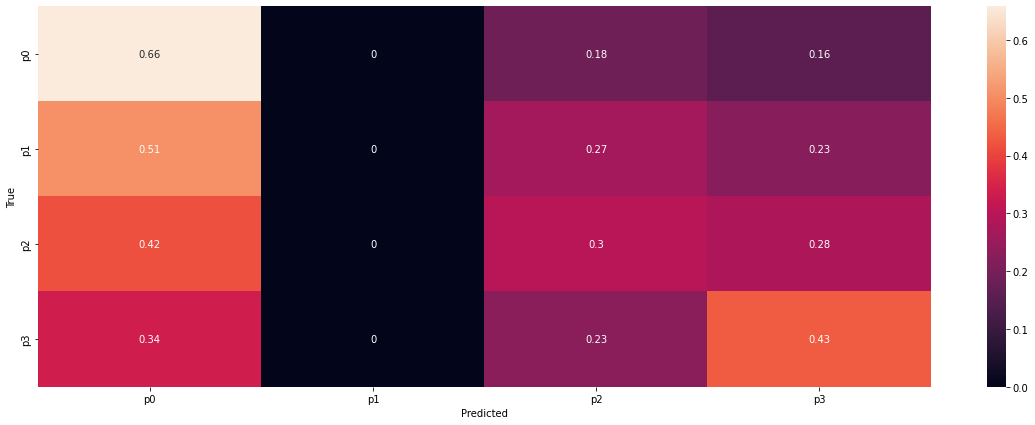

In [ ]:
y_pred = np.argmax(y_probs, axis=-1)
print(classification_report(valid_labels, y_pred))

plot_confusion_matrix(valid_labels, y_pred, label_names)

wrong_guesses = np.where(valid_labels != y_pred)

In [ ]:
text = np.array(clean_dataset_test['text'])
titles = np.array(clean_dataset_test['title'])
bodies = np.array(clean_dataset_test['body'])

In [ ]:
for i in wrong_guesses[0][:5]:
    print('-'*50)
    print(titles[i])
    print('+'*10)
    print(bodies[i])
    print('+'*10)
    print(text[i])
    print('+'*10)
    print(valid_labels[i])
    print(y_pred[i])

--------------------------------------------------
Path.resolve(other) java.nio.file.Path method
++++++++++
<p>Directly from this <a href="http://docs.oracle.com/javase/7/docs/api/java/nio/file/Path.html#resolve%28java.nio.file.Path%29" rel="noreferrer">API</a>:</p>

<blockquote>
  <p>resolve</p>
  
  <p>Path resolve(Path other)</p>
  
  <p>Resolve the given path against this path.</p>
  
  <p><strong>If the other parameter is an absolute path then this method trivially</strong>
   <strong>returns other.</strong> If other is an empty path then this method trivially
  returns this path. Otherwise this method considers this path to be a
  directory and resolves the given path against this path. In the
  simplest case, the given path does not have a root component, in which
  case this method joins the given path to this path and returns a
  resulting path that ends with the given path. <strong>Where the given path has</strong>
   <strong>a root component then resolution is highly impleme

In [ ]:
wrong_guesses[0][1]

4

In [ ]:
wrong_guesses[:10]

(array([    3,     4,     7, ..., 39251, 39252, 39254]),)

In [ ]:
np.unique(valid_labels)

array([0, 1, 2, 3])

In [ ]:
np.bincount(y_pred)

array([16906,  4269,  9442,  8638])